# Image Classification Project using TensorFlow
## Cat Classifier

### Importing Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import h5py
import math
import tensorflow as tf
from tensorflow.python.framework import ops
tf.disable_eager_execution()

### Loading Dataset

In [2]:
def load_dataset():
    train_dataset = h5py.File(r'C:\Users\user\Desktop\Data Science\train_catvnoncat.h5', 'r')
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File(r'C:\Users\user\Desktop\Data Science\test_catvnoncat.h5', 'r')
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
X_train_orig, y_train, X_test_orig, y_test, classes = load_dataset()

### Determing Shapes of Train and Test Datasets

In [3]:
print("X_train_orig Shape : ", X_train_orig.shape)
print("y_train Shape : ", y_train.shape)
print("X_test_orig Shape : ", X_test_orig.shape)
print("y_test Shape : ", y_test.shape)

X_train_orig Shape :  (209, 64, 64, 3)
y_train Shape :  (1, 209)
X_test_orig Shape :  (50, 64, 64, 3)
y_test Shape :  (1, 50)


### Displaying an Image from the Train Dataset

y =  1


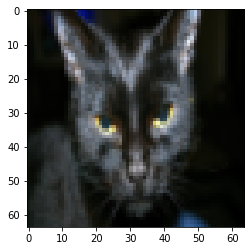

In [4]:
plt.figure()
index = 25
plt.imshow(X_train_orig[index])
print("y = ", np.squeeze(y_train[:, index]))

### Setting Random Seed

In [5]:
np.random.seed(1)

### Flattening Images

In [6]:
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
print("X_train Shape : ", X_train_flatten.shape)
print("X_test Shape : ", X_test_flatten.shape)

X_train Shape :  (12288, 209)
X_test Shape :  (12288, 50)


### Normalizing Dataset

In [7]:
X_train = X_train_flatten / 255
X_test = X_test_flatten / 255

### Creating Placeholders

In [8]:
def create_placeholders(fx, fy):
    X = tf.placeholder(tf.float32, [fx, None], name = "X")
    Y = tf.placeholder(tf.float32, [fy, None], name = "Y")
    return X, Y

### Initializing Parameters

In [9]:
parameters = {}
def init_params():
    W1 = tf.get_variable("W1", [12, 12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [12,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [6,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1, 6], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [1,1], initializer = tf.zeros_initializer())
    return W1,b1,W2,b2,W3,b3

### Forward Propagation

In [10]:
cache = {}
def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    Z1 = tf.add(tf.matmul(W1, X), b1)                                        
    A1 = tf.nn.relu(Z1)                                             
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                           
    A2 = tf.nn.relu(Z2)                                           
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    return Z3

### Cost Computation

In [11]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))
    return cost

### Generating Random Mini Batches

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 32, seed = 1):
    m = X.shape[1]
    mini_batches = []
    np.random.seed(seed)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

## Putting It All Together

### Neural Network Model

In [13]:
def nn_model(X_train, Y_train, learning_rate = 0.0001, num_epochs = 1500, minibatch_size = 32):
    ops.reset_default_graph()
    (fx, m) = X_train.shape                       
    fy = Y_train.shape[0] 
    costs = []                              
    X, Y = create_placeholders(fx, fy)
    W1,b1,W2,b2,W3,b3 = init_params()
    Z3 = forward_propagation(X, W1, b1, W2, b2, W3, b3)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
   
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.                       
            num_minibatches = int(m / minibatch_size) 
            seed = 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / minibatch_size

            if epoch % 100 == 0:
                costs.append(epoch_cost)
                print("Cost after", epoch, "epochs : ", epoch_cost)
                
        plt.plot(np.squeeze(costs), '-o')
        plt.ylabel('Cost')
        plt.xlabel('Iterations')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()

        W1 = sess.run(W1)
        b1 = sess.run(b1)
        W2 = sess.run(W2)
        b2 = sess.run(b2)
        W3 = sess.run(W3)
        b3 = sess.run(b3)
        
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy :", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy :", accuracy.eval({X: X_test, Y: y_test}))
        return W1,b1,W2,b2,W3,b3

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Cost after 0 epochs :  0.1472276970744133
Cost after 100 epochs :  0.03615818405523896
Cost after 200 epochs :  0.01376394322142005
Cost after 300 epochs :  0.00476876538596116
Cost after 400 epochs :  0.002254220235045068
Cost after 500 epochs :  0.0011877881188411266
Cost after 600 epochs :  0.0006708194414386526
Cost after 700 epochs :  0.0003956019936595112
Cost after 800 epochs :  0.00024146477335307281
Cost after 900 epochs :  0.000150907715124049
Cost after 1000 epochs :  9.581017366144806e-05
Cost after 1100 epochs :  6.17057689

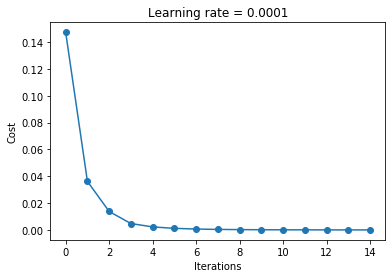

Train Accuracy : 1.0
Test Accuracy : 1.0


In [14]:
W1,b1,W2,b2,W3,b3 = nn_model(X_train, y_train)

### Prediction on My Image

In [15]:
def predict(X, W1, b1, W2, b2, W3, b3):
    
    W1 = tf.convert_to_tensor(W1)
    b1 = tf.convert_to_tensor(b1)
    W2 = tf.convert_to_tensor(W2)
    b2 = tf.convert_to_tensor(b2)
    W3 = tf.convert_to_tensor(W3)
    b3 = tf.convert_to_tensor(b3)
    
    x = tf.placeholder("float", [12288, 1])
    
    z3 = forward_propagation(x, W1, b1, W2, b2, W3, b3)
    p = tf.argmax(z3)
    
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

Algorithm predicts a non-cat picture.


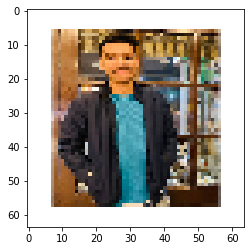

In [22]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
img_path = r'C:\Users\user\Desktop\Data Science\thesecretphoenix_20200404_1.png'
img = image.load_img(img_path, target_size=(64, 64))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x = x.reshape(x.shape[0], -1).T
p = np.squeeze(predict(x, W1, b1, W2, b2, W3, b3))
if (p == 0):
    print("Algorithm predicts a non-cat picture.")
else:
    print("Algorithm predicts a cat picture.")